#Getting Data

In [1]:
import torch
from torch import nn


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests
import zipfile
from pathlib import Path
import os

# setting up data path
datapath = Path('data/')
imagepath = Path(datapath/"food_images")

if imagepath.is_dir():
  print("image path dir already exists")
else:
    print("making directory")
    imagepath.mkdir(parents=True,exist_ok=True)


with open(datapath / "food_images.zip",'wb') as f:
  request = requests.get("https://programmingoceanacademy.s3.ap-southeast-1.amazonaws.com/image_classification_dataset.zip")
  print("downloading the data ")
  f.write(request.content)

with zipfile.ZipFile(datapath / "food_images.zip","r") as zip_ref:
  print("unzipping the data")
  zip_ref.extractall(imagepath)



making directory
downloading the data 
unzipping the data


In [4]:
os.remove(datapath / "food_images.zip")

data set looks like this

`data->food_images->dataset->train-> class1 -> class 2 -> class 3 `</br>
`data->food_images->dataset->test-> class1 -> class 2 -> class 3 `

In [5]:
imagepath


PosixPath('data/food_images')

In [6]:
train_dir = imagepath/"dataset/train"
test_dir = imagepath/"dataset/test"

#2. Data preparation and EDA

In [7]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

In [8]:
walk_through_dir(imagepath)

there are 1 directories and 0 in data/food_images
there are 2 directories and 0 in data/food_images/dataset
there are 4 directories and 0 in data/food_images/dataset/test
there are 0 directories and 75 in data/food_images/dataset/test/cup_cakes
there are 0 directories and 75 in data/food_images/dataset/test/macarons
there are 0 directories and 75 in data/food_images/dataset/test/chocolate_cake
there are 0 directories and 75 in data/food_images/dataset/test/sushi
there are 4 directories and 0 in data/food_images/dataset/train
there are 0 directories and 250 in data/food_images/dataset/train/cup_cakes
there are 0 directories and 250 in data/food_images/dataset/train/macarons
there are 0 directories and 250 in data/food_images/dataset/train/chocolate_cake
there are 0 directories and 250 in data/food_images/dataset/train/sushi


random image path data/food_images/dataset/train/macarons/88207.jpg
image heinght 384
image width 512
image channel RGB


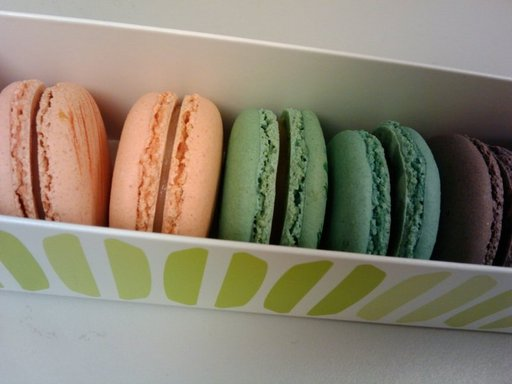

In [9]:
import random
from PIL import Image

image_path_list = list(imagepath.glob("*/*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"random image path {random_image_path}")
print(f"image heinght {img.height}")
print(f"image width {img.width}")
print(f"image channel {img.mode}")
img

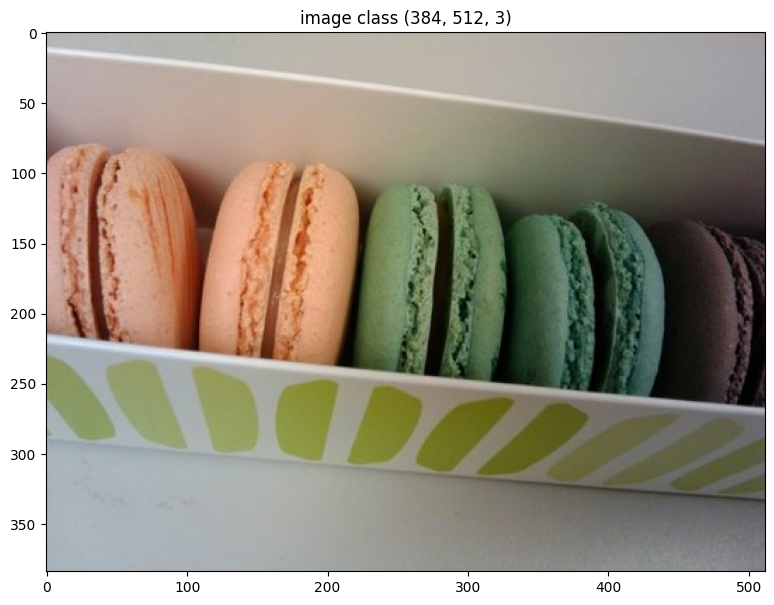

In [10]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.title(f"image class {image_as_array.shape}")
plt.imshow(image_as_array);

#3. Transforming Data

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision import datasets


In [12]:
data_transform = T.Compose(
   [ T.Resize(size=(64,64)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor()]
)

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [14]:
train_dataset = datasets.ImageFolder(train_dir,transform=data_transform,target_transform=None)
test_dataset = datasets.ImageFolder(test_dir,transform=data_transform,target_transform=None)

In [15]:
class_names = train_dataset.classes
class_names

['chocolate_cake', 'cup_cakes', 'macarons', 'sushi']

In [16]:
class_dict = train_dataset.class_to_idx
class_dict


{'chocolate_cake': 0, 'cup_cakes': 1, 'macarons': 2, 'sushi': 3}

In [17]:
len(train_dataset), len(test_dataset)

(1000, 300)

In [18]:
import os
from torch.utils.data import DataLoader  # fixed the typo

batch_size = 32
NUM_OF_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=NUM_OF_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             num_workers=NUM_OF_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78d9bee1aad0>,
 <torch.utils.data.dataloader.DataLoader at 0x78d9bee13610>)

# Building the model architecture

In [19]:
import torch
import torch.nn as nn

class Vgg(nn.Module):
    '''
    Creating the VGG from scratch
    '''
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      stride=(1, 1),
                      kernel_size=(3, 3),   # fixed spelling
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=(1, 1),
                      kernel_size=(3, 3),   # fixed spelling
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=(1, 1),
                      kernel_size=(3, 3),
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=(1, 1),
                      kernel_size=(3, 3),
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [20]:
torch.manual_seed(42)
model = Vgg(input_shape=3,
            hidden_units=10,
            output_shape=len(class_names)).to(device)
model

Vgg(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

# Creating a  testing and training loop

In [21]:
def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: device):

  '''
    this function trains the model
    on the dataloader and optimizes the model
    params to get a better results
  '''
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X,y) in  enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [22]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: device):


    model.eval()

    test_loss,test_acc = 0,0
    with torch.inference_mode():
      for batch, (X,y) in enumerate(dataloader):
         X, y = X.to(device), y.to(device)
         test_pred = model(X)
         loss = loss_fn(test_pred,y)
         test_loss += loss.item()
         test_pred_class = torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
         test_acc += (test_pred_class == y).sum().item()/len(test_pred)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs = 5,
    device = device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Epoch: {epoch} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_OF_EPOCHS = 50
model = Vgg(input_shape=3,
            hidden_units=10,
            output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(),
                             lr =0.0005)

from timeit import default_timer as timer

timer_start = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_OF_EPOCHS,
                      device=device)

end_time = timer()
print(f"total training time {end_time - timer_start}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3926 | Train acc: 0.2334
Epoch: 0 | Test loss: 1.3884 | Test acc: 0.2344
Epoch: 1 | Train loss: 1.3860 | Train acc: 0.2549
Epoch: 1 | Test loss: 1.3802 | Test acc: 0.4042
Epoch: 2 | Train loss: 1.3698 | Train acc: 0.3613
Epoch: 2 | Test loss: 1.3442 | Test acc: 0.3896
Epoch: 3 | Train loss: 1.2604 | Train acc: 0.4248
Epoch: 3 | Test loss: 1.2459 | Test acc: 0.4271
Epoch: 4 | Train loss: 1.1954 | Train acc: 0.4561
Epoch: 4 | Test loss: 1.2497 | Test acc: 0.4219
Epoch: 5 | Train loss: 1.1877 | Train acc: 0.4521
Epoch: 5 | Test loss: 1.2266 | Test acc: 0.4042
Epoch: 6 | Train loss: 1.1830 | Train acc: 0.4453
Epoch: 6 | Test loss: 1.2357 | Test acc: 0.4135
Epoch: 7 | Train loss: 1.1667 | Train acc: 0.4639
Epoch: 7 | Test loss: 1.2143 | Test acc: 0.4448
Epoch: 8 | Train loss: 1.1382 | Train acc: 0.4941
Epoch: 8 | Test loss: 1.2459 | Test acc: 0.4375
Epoch: 9 | Train loss: 1.1424 | Train acc: 0.4893
Epoch: 9 | Test loss: 1.2190 | Test acc: 0.4552
Epoch: 10 | Train lo

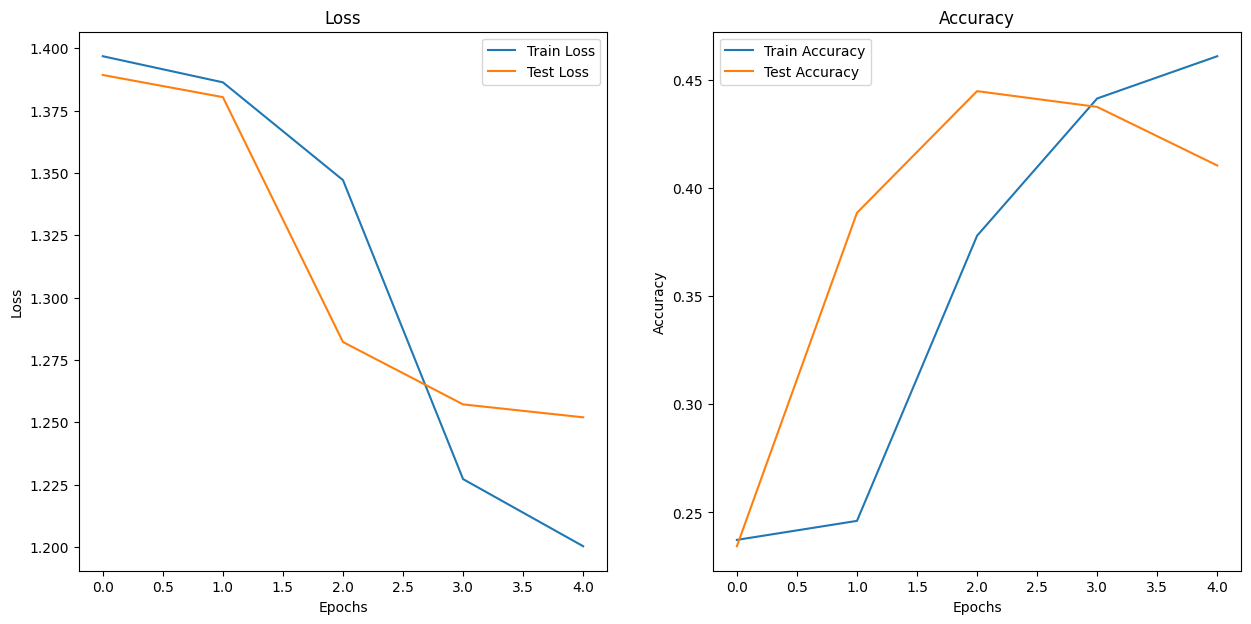

In [28]:
import matplotlib.pyplot as plt

def plot_results(results):
    """
    Plots training curves of a results dictionary.
    Expected keys in results:
    'train_loss', 'test_loss', 'train_acc', 'test_acc'
    """

    # Get the loss values (training and test)
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values (training and test)
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Number of epochs
    epochs = range(len(train_loss))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, test_accuracy, label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_results(model_results )